# Interactive Jupyter Notebook for the Thesis Network

This notebook gives a simple plug-and-play solution to try out different parameter settings and plot different data. On the one hand, this simplifies bugfixing, but also permits to deepen the understanding of the network dynamics.

First we import all necessary libraries and set meta parameters, e.g. verbosity and the seed for the random number generator.

In [1]:
from modules.stimulusReconstruction import fourier_trans, direct_stimulus_reconstruction
from modules.createStimulus import *
from modules.thesisUtils import arg_parse
from createThesisNetwork import network_factory, NETWORK_TYPE
from modules.networkAnalysis import mutual_information_hist, error_distance

import numpy as np
import matplotlib.pyplot as plt
import nest


VERBOSITY = 3
nest.set_verbosity("M_ERROR")
np.random.seed(0)

Next, we define all parameters of our network. First, we set the network type and the type of input we want to use. Then we define the actual network parameters.

In [2]:
network_type=NETWORK_TYPE["local_circ_patchy_sd"]
input_type=INPUT_TYPE["plain"]

simulation_time = 1000.
num_neurons = int(1e3)  # Number of neurons in the sheet with sensory neurons
cap_s = 1.  # Weight of excitatory recurrent synapses
inh_weight = -15.  # Weight of inhibitory recurrent synapses
all_same_input_current = False  # Flag is set to True if all sensory neurons should receive the same ff input
p_loc = 0.6  # Connection probability of local connections
p_lr = 0.2  # Connection probability of long-range connections

In the following line, we load the input stimulus, meaning the type of image we have defined above.

In [3]:
input_stimulus = stimulus_factory(input_type)

The network is created through a factory interface to simplify the creation process. It returns network object, which establishes the connections, receptive fields and orientation map through the function call `network.create_network()`. 

In [4]:
network = network_factory(
    input_stimulus,
    network_type=network_type,
    num_sensory=num_neurons,
    all_same_input_current=all_same_input_current,
    cap_s=cap_s,
    inh_weight=inh_weight,
    p_loc=p_loc,
    p_lr=p_lr,
    verbosity=VERBOSITY
)
network.create_network()


#####################	Determine feedforward weight

#####################	Create sensory layer

#####################	Create stimulus tuning map


/usr/lib/python3.6/dist-packages/nest/lib/hl_api_helper.py:127: UserWarning:
GetNodes is deprecated and will be removed in NEST 3.0. Use             GIDCollection instead.



#####################	Create central points for receptive fields

#####################	Create connections between receptors and sensory neurons

#####################	Create local circular connections

#####################	Create long-range patchy stimulus dependent connections


To investigate the response we simulate the network for a given time. The return parameters of the simulation function are the firing rates of every neuron, which neurons spiked in chronological order and the respective spike times.

In [5]:
firing_rates, (spikes_s, time_s) = network.simulate(simulation_time)

if VERBOSITY > 0:
    average_firing_rate = np.mean(firing_rates)
    print("\n#####################\tAverage firing rate: %s" % average_firing_rate)


#####################	Simulate

#####################	Average firing rate: 9.908


If required, it's possible to plot the neural response coloured with respect to their respective stimulus tuning.

In [6]:
if VERBOSITY > 3:
    print("\n#####################\tPlot firing pattern over time")
    positions = tp.GetPosition(spikes_s.tolist())
    plot_colorbar(plt.gcf(), plt.gca(), num_stim_classes=network.num_stim_discr)
    for s, t, pos in zip(spikes_s, time_s, positions):
        x_grid, y_grid = coordinates_to_cmap_index(network.layer_size, pos, network.spacing_perlin)
        stim_class = network.color_map[x_grid, y_grid]
        plt.plot(
            t,
            s,
            marker='.',
            markerfacecolor=list(mcolors.TABLEAU_COLORS.items())[stim_class][0]
            if s not in network.torus_inh_nodes else 'k',
            markeredgewidth=0
        )
    plt.show()

The network response can be plotted with respect to space. This means that the neurons with a high firing rate are plotted opaquely, whereas neurons that exhibit only a low firing rate are depicted more transparently.


#####################	Plot firing pattern over space


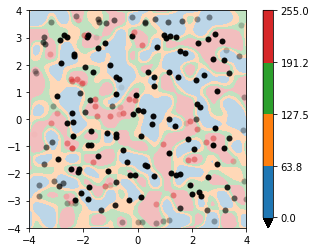

In [7]:
if VERBOSITY > 2:
    print("\n#####################\tPlot firing pattern over space")
    plot_colorbar(plt.gcf(), plt.gca(), num_stim_classes=network.num_stim_discr)
    for pos, fr, neuron in zip(network.torus_layer_positions, firing_rates, network.torus_layer_nodes):
        if neuron not in network.torus_inh_nodes:
            x_grid, y_grid = coordinates_to_cmap_index(network.layer_size, pos, network.spacing_perlin)
            stim_class = network.color_map[x_grid, y_grid]
            plt.plot(
                pos[0],
                pos[1],
                marker='o',
                markerfacecolor=list(mcolors.TABLEAU_COLORS.items())[stim_class][0],
                markeredgewidth=0,
                alpha=fr/float(max(firing_rates))
            )
        else:
            plt.plot(
                pos[0],
                pos[1],
                marker='o',
                markerfacecolor='k',
                markeredgewidth=0,
                alpha=fr/float(max(firing_rates))
            )

    plt.imshow(
        network.color_map,
        cmap=custom_cmap(),
        alpha=0.3,
        origin=(network.color_map.shape[0] // 2, network.color_map.shape[1] // 2),
        extent=(
            -network.layer_size / 2.,
            network.layer_size / 2.,
            -network.layer_size / 2.,
            network.layer_size / 2.
        )
    )
    plt.show()

We try to reconstruct the original stimulus. So far, this has been done through weighting the respective tuning with the firing rate. However, it can be assumed that information is lost through non-linearities.

In [8]:
# #################################################################################################################
# Reconstruct stimulus
# #################################################################################################################
# Reconstruct input stimulus
if VERBOSITY > 0:
    print("\n#####################\tReconstruct stimulus")

reconstruction = direct_stimulus_reconstruction(
    firing_rates,
    network.adj_rec_sens_mat,
    network.tuning_weight_vector
)


#####################	Reconstruct stimulus


If the verbosity flag is set high enought the reconstructed image is displayed together with the original input and the orientation map.

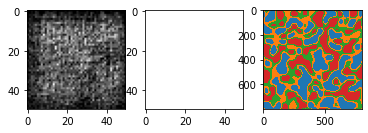

In [9]:
if VERBOSITY > 1:
    _, fig_2 = plt.subplots(1, 3)
    fig_2[0].imshow(reconstruction, cmap='gray', vmin=0, vmax=255)
    fig_2[1].imshow(input_stimulus, cmap='gray', vmin=0, vmax=255)
    fig_2[2].imshow(network.color_map, cmap=custom_cmap())
    plt.show()